##Research questions
We will try to answer the below mentioned questions in our data analysis, model implementation and predictions.
1.   What are the key contextual features that might influence the need for IV antibiotics treatment?  
2.  Are there any specific biomarkers or medical histories that significantly impact the model's predictions?
3. How can the model be integrated into clinical decision-making processes to assist healthcare professionals?

In [ ]:
#importing libraries required for this project
import pandas as pd
import numpy as np
from sklearn.metrics import recall_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats
from IPython.display import display, HTML

In [ ]:
# Function to create scrollable table within a small window
def create_scrollable_table(df, table_id, title):
    html = f'<h3>{title}</h3>'
    html += f'<div id="{table_id}" style="height:200px; overflow:auto;">'
    html += df.to_html()
    html += '</div>'
    return html

## Data Loading

In [ ]:
#Load data
filepath = 'Sepsis Cases - Event Log.csv'
data = pd.read_csv(filepath)
print(data.shape) #getting the number of records and features of the data
data.head()#printing the first 5 records in the data

(15214, 34)


,Case ID,Activity,Complete Timestamp,Variant,Variant index,lifecycle:transition,org:group,InfectionSuspected,DiagnosticBlood,DisfuncOrg,...,SIRSCritLeucos,Oligurie,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Leucocytes,CRP,LacticAcid
0,A,ER Registration,2014-10-22 19:15:41.000,Variant 63,63,complete,A,True,True,True,...,False,False,True,A,False,True,True,NaN,NaN,NaN
1,A,Leucocytes,2014-10-22 19:27:00.000,Variant 63,63,complete,B,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.6,NaN,NaN
2,A,CRP,2014-10-22 19:27:00.000,Variant 63,63,complete,B,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN
3,A,LacticAcid,2014-10-22 19:27:00.000,Variant 63,63,complete,B,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2
4,A,ER Triage,2014-10-22 19:33:37.000,Variant 63,63,complete,C,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are 15214 records with 34 features in the dataset

## Exploratory Data Analysis

In [ ]:
#checking for missing values in columns in data, Not checking other columns as the data is case based only the
#particular events or columns will have values, others will be blank
print(data['Case ID'].isna().sum())
print((data['Activity'].isna().sum()))


24
0


In [ ]:
#filling missing values for CaseID column with 'NA'
data['Case ID'].fillna('NA',inplace = True)
print(data['Case ID'].isna().sum())

0


In [ ]:
#checking the datatype of different columns
datatypes = data.dtypes
html_datatypes = create_scrollable_table(datatypes.to_frame(), 'datatypes', 'Different data types in the dataset')
display(HTML(html_datatypes))

,0
Case ID,object
Activity,object
Complete Timestamp,object
Variant,object
Variant index,int64
lifecycle:transition,object
org:group,object
InfectionSuspected,object
DiagnosticBlood,object
DisfuncOrg,object


In [ ]:
# Get the descriptive statistics for numerical columns
data.describe()

,Variant index,Age,Leucocytes,CRP,LacticAcid
count,15214.000000,1050.000000,3361.00000,3123.000000,1454.000000
mean,399.948863,70.080952,12.94936,113.745757,1.949106
std,256.580963,17.356744,14.99533,86.775355,1.478633
min,1.000000,20.000000,0.20000,5.000000,0.200000
25%,174.000000,60.000000,7.70000,43.000000,1.100000
50%,393.000000,75.000000,11.00000,95.000000,1.600000
75%,622.000000,85.000000,15.00000,162.000000,2.300000
max,846.000000,90.000000,381.30000,573.000000,14.900000


From the summary statistics we can see that there are high variations between values for Age, Leucocytes, CRP and Lactic acid columns. So, scaling is required for these columns.

In [ ]:
# Summary statistics for categorical features
categorical_features = data.select_dtypes(include=[object])
cat_summary_stats = categorical_features.describe().T
html_categorical = create_scrollable_table(cat_summary_stats, 'categorical_features', 'Summary statistics for categorical features')
display(HTML(html_categorical ))

,count,unique,top,freq
Case ID,15214,1050,NGA,185
Activity,15214,16,Leucocytes,3383
Complete Timestamp,15214,9469,2014-08-25 16:00:00.000,17
Variant,15214,846,Variant 710,185
lifecycle:transition,15214,1,complete,15214
org:group,15214,26,B,8111
InfectionSuspected,1050,2,True,848
DiagnosticBlood,1050,2,True,823
DisfuncOrg,1050,2,False,981
SIRSCritTachypnea,1050,2,True,601


From the above table we can see that there 15214 records with 1050 unique cases, 16 unique events and Leucocytes is having highest frequency of 3383 times.

In [ ]:
#Dropping columns not important for our analysis
data = data.drop(columns = ['lifecycle:transition','Variant','Variant index'])
data.shape

(15214, 31)

In [ ]:
# converting boolean values to integers as boolean values cannot be used in machine learning models.
bin_val = ['InfectionSuspected','DiagnosticBlood','DisfuncOrg','SIRSCritTachypnea','Hypotensie','SIRSCritHeartRate',
           'Infusion','DiagnosticArtAstrup','DiagnosticIC','DiagnosticSputum','DiagnosticLiquor','DiagnosticOther','SIRSCriteria2OrMore',
           'DiagnosticXthorax','SIRSCritTemperature','DiagnosticUrinaryCulture','SIRSCritLeucos','Oligurie',
                'DiagnosticLacticAcid','Hypoxie','DiagnosticUrinarySediment','DiagnosticECG']
#filling in values from the first row for each case for the values in following rows
for i in bin_val:
    data[i]= data.groupby('Case ID')[i].transform("first")
#Changing data type to int
for i in bin_val:
    data[i]= data[i].astype(int)

In [ ]:
# checking if columns have been converted to boolean values
data.head(10)

,Case ID,Activity,Complete Timestamp,org:group,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,...,SIRSCritLeucos,Oligurie,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Leucocytes,CRP,LacticAcid
0,A,ER Registration,2014-10-22 19:15:41.000,A,1,1,1,1,1,1,...,0,0,1,A,0,1,1,NaN,NaN,NaN
1,A,Leucocytes,2014-10-22 19:27:00.000,B,1,1,1,1,1,1,...,0,0,1,NaN,0,1,1,9.6,NaN,NaN
2,A,CRP,2014-10-22 19:27:00.000,B,1,1,1,1,1,1,...,0,0,1,NaN,0,1,1,NaN,21.0,NaN
3,A,LacticAcid,2014-10-22 19:27:00.000,B,1,1,1,1,1,1,...,0,0,1,NaN,0,1,1,NaN,NaN,2.2
4,A,ER Triage,2014-10-22 19:33:37.000,C,1,1,1,1,1,1,...,0,0,1,NaN,0,1,1,NaN,NaN,NaN
5,A,ER Sepsis Triage,2014-10-22 19:34:00.000,A,1,1,1,1,1,1,...,0,0,1,NaN,0,1,1,NaN,NaN,NaN
6,A,IV Liquid,2014-10-22 22:03:47.000,A,1,1,1,1,1,1,...,0,0,1,NaN,0,1,1,NaN,NaN,NaN
7,A,IV Antibiotics,2014-10-22 22:03:47.000,A,1,1,1,1,1,1,...,0,0,1,NaN,0,1,1,NaN,NaN,NaN
8,A,Admission NC,2014-10-22 22:13:19.000,D,1,1,1,1,1,1,...,0,0,1,NaN,0,1,1,NaN,NaN,NaN
9,A,CRP,2014-10-24 17:00:00.000,B,1,1,1,1,1,1,...,0,0,1,NaN,0,1,1,NaN,109.0,NaN


## Feature Construction
Q1: What are the key contextual features that might influence the need for IV antibiotics treatment?
As per the domain knowledge from literature review we have identified a few features from the dataset that is important to decide whether the patient need antibiotics treatment or not. So based on these featres we are constructing some additional features to aid prediction.

In [ ]:
#checking SIRS criteria, if any of these two criterias are satisfied we will st the new column 'SIRSCriteria2OrMore_satisfied'
def check_SIRS(each_row):
    if (each_row['SIRSCritTemperature']==1 & each_row['SIRSCritTachypnea']==1) | (each_row['SIRSCritTemperature']==1 & each_row['SIRSCritHeartRate']==1)  | (each_row['SIRSCritHeartRate']==1 & each_row['SIRSCritTachypnea']==1):
        return(1)
    else:
      return(0)

data['SIRSCriteria2OrMore_satisfied'] = data.apply(check_SIRS, axis=1)
data['SIRSCriteria2OrMore_satisfied'].value_counts()


1    13769
0     1445
Name: SIRSCriteria2OrMore_satisfied, dtype: int64

In [ ]:
#checking other biomarkers which are important in deciding whether patient has any infections which
#can lead to sepsis and setting column 'add_biomark_check' as 'True'.
def check_bio(each_row):
      if  (each_row['InfectionSuspected']==1 | each_row['DisfuncOrg']==1 | each_row['Infusion']==1 | each_row['Oligurie']==1  | each_row['Hypotensie']==1 | each_row['Hypoxie']==1):
          return(1)
      else:
          return(0)
data['add_biomark_check'] = data.apply(check_bio, axis=1)
data['add_biomark_check'].value_counts()

1    13526
0     1688
Name: add_biomark_check, dtype: int64

In [ ]:
# Create a new column 'Age_Risk' if the person is older than 65 or less than one
data['Age_Risk'] = data['Age'].apply(lambda x: 1 if  x > 65 or x < 1 else 0)
data['Age_Risk'].value_counts()

0    14536
1      678
Name: Age_Risk, dtype: int64

In [ ]:
#scaling age column. Other numerical variables will be scaled after aggregating data by case.
scaler = MinMaxScaler(feature_range=(-1, 1))
data['Age'] = scaler.fit_transform(data['Age'].values.reshape(-1,1))
data.head()

,Case ID,Activity,Complete Timestamp,org:group,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,...,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Leucocytes,CRP,LacticAcid,SIRSCriteria2OrMore_satisfied,add_biomark_check,Age_Risk
0,A,ER Registration,2014-10-22 19:15:41.000,A,1,1,1,1,1,1,...,A,0,1,1,NaN,NaN,NaN,1,1,1
1,A,Leucocytes,2014-10-22 19:27:00.000,B,1,1,1,1,1,1,...,NaN,0,1,1,9.6,NaN,NaN,1,1,0
2,A,CRP,2014-10-22 19:27:00.000,B,1,1,1,1,1,1,...,NaN,0,1,1,NaN,21.0,NaN,1,1,0
3,A,LacticAcid,2014-10-22 19:27:00.000,B,1,1,1,1,1,1,...,NaN,0,1,1,NaN,NaN,2.2,1,1,0
4,A,ER Triage,2014-10-22 19:33:37.000,C,1,1,1,1,1,1,...,NaN,0,1,1,NaN,NaN,NaN,1,1,0


In [ ]:
# generating an activity index to indicate the order of individual activities
data['Complete Timestamp'] = pd.to_datetime(data['Complete Timestamp'])
data['activity_index'] = data.groupby('Case ID')['Complete Timestamp'].rank(method = 'first')
data.head(10)

,Case ID,Activity,Complete Timestamp,org:group,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,...,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Leucocytes,CRP,LacticAcid,SIRSCriteria2OrMore_satisfied,add_biomark_check,Age_Risk,activity_index
0,A,ER Registration,2014-10-22 19:15:41,A,1,1,1,1,1,1,...,0,1,1,NaN,NaN,NaN,1,1,1,1.0
1,A,Leucocytes,2014-10-22 19:27:00,B,1,1,1,1,1,1,...,0,1,1,9.6,NaN,NaN,1,1,0,2.0
2,A,CRP,2014-10-22 19:27:00,B,1,1,1,1,1,1,...,0,1,1,NaN,21.0,NaN,1,1,0,3.0
3,A,LacticAcid,2014-10-22 19:27:00,B,1,1,1,1,1,1,...,0,1,1,NaN,NaN,2.2,1,1,0,4.0
4,A,ER Triage,2014-10-22 19:33:37,C,1,1,1,1,1,1,...,0,1,1,NaN,NaN,NaN,1,1,0,5.0
5,A,ER Sepsis Triage,2014-10-22 19:34:00,A,1,1,1,1,1,1,...,0,1,1,NaN,NaN,NaN,1,1,0,6.0
6,A,IV Liquid,2014-10-22 22:03:47,A,1,1,1,1,1,1,...,0,1,1,NaN,NaN,NaN,1,1,0,7.0
7,A,IV Antibiotics,2014-10-22 22:03:47,A,1,1,1,1,1,1,...,0,1,1,NaN,NaN,NaN,1,1,0,8.0
8,A,Admission NC,2014-10-22 22:13:19,D,1,1,1,1,1,1,...,0,1,1,NaN,NaN,NaN,1,1,0,9.0
9,A,CRP,2014-10-24 17:00:00,B,1,1,1,1,1,1,...,0,1,1,NaN,109.0,NaN,1,1,0,10.0


In [ ]:
#filter the activity 'IV Antibiotic', for each Case ID and create new dataset
data_Antibiotic = data.loc[data['Activity'] == 'IV Antibiotics'].groupby('Case ID')['Activity'].count().reset_index()
data_Antibiotic.columns = ['Case ID','IV_Antibiotics']
print(data_Antibiotic.shape)
print(data_Antibiotic.head(20))

(823, 2)
   Case ID  IV_Antibiotics
0        A               1
1       AA               1
2      AAA               1
3       AB               1
4      ABA               1
5       AC               1
6      ACA               1
7       AD               1
8      ADA               1
9       AE               1
10     AEA               1
11      AF               1
12     AFA               1
13     AGA               1
14      AH               1
15     AHA               1
16      AI               1
17     AIA               1
18      AJ               1
19      AK               1


### Generate prefixes by a special condition
E.g, consider first four events in the activity_index after dropping 'ER Triage' and 'ER Sepsis Triage'(these events do not add value to our analysis)as the prefix for prediction.

In [ ]:
data_prefix = data.merge(data_Antibiotic, on = 'Case ID',how = 'left' ) #merge the antibiotic dataframe with the dataset
data_prefix = data_prefix.drop(data_prefix[(data_prefix['Activity'] == 'ER Triage')|(data_prefix['Activity'] == 'ER Sepsis Triage')].index)
data_prefix = data_prefix.loc[data_prefix['activity_index']< 5] #prefix filteration
data_prefix.head(10)

,Case ID,Activity,Complete Timestamp,org:group,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,...,DiagnosticUrinarySediment,DiagnosticECG,Leucocytes,CRP,LacticAcid,SIRSCriteria2OrMore_satisfied,add_biomark_check,Age_Risk,activity_index,IV_Antibiotics
0,A,ER Registration,2014-10-22 19:15:41,A,1,1,1,1,1,1,...,1,1,NaN,NaN,NaN,1,1,1,1.0,1.0
1,A,Leucocytes,2014-10-22 19:27:00,B,1,1,1,1,1,1,...,1,1,9.6,NaN,NaN,1,1,0,2.0,1.0
2,A,CRP,2014-10-22 19:27:00,B,1,1,1,1,1,1,...,1,1,NaN,21.0,NaN,1,1,0,3.0,1.0
3,A,LacticAcid,2014-10-22 19:27:00,B,1,1,1,1,1,1,...,1,1,NaN,NaN,2.2,1,1,0,4.0,1.0
22,B,ER Registration,2014-12-21 20:04:24,A,1,1,0,1,0,1,...,1,1,NaN,NaN,NaN,1,1,0,1.0,1.0
24,B,CRP,2014-12-21 20:36:00,B,1,1,0,1,0,1,...,1,1,NaN,240.0,NaN,1,1,0,3.0,1.0
25,B,LacticAcid,2014-12-21 20:36:00,B,1,1,0,1,0,1,...,1,1,NaN,NaN,0.8,1,1,0,4.0,1.0
34,C,ER Registration,2014-02-10 04:29:29,A,1,1,0,0,0,1,...,1,1,NaN,NaN,NaN,1,1,0,1.0,1.0
37,C,Leucocytes,2014-02-10 05:06:00,B,1,1,0,0,0,1,...,1,1,15.4,NaN,NaN,1,1,0,4.0,1.0
48,D,ER Registration,2014-07-10 19:52:00,A,1,1,0,1,0,1,...,0,1,NaN,NaN,NaN,1,1,1,1.0,1.0


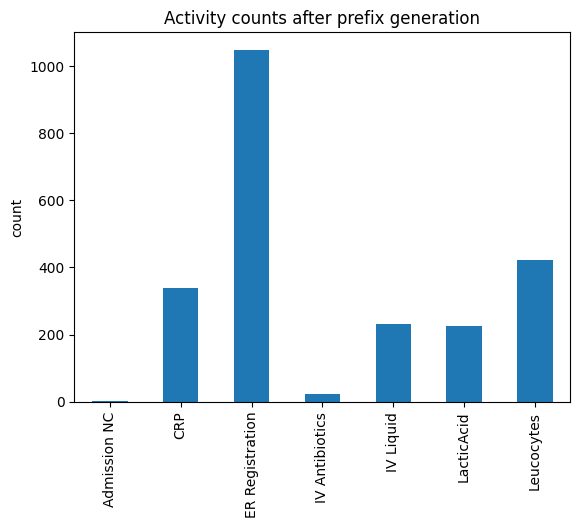

In [ ]:
#plotting the activities in the dataset after slecting first 5 events as prefix
data_prefix['Activity'].value_counts().sort_index().plot(kind='bar', rot='vertical', ylabel='count', title = 'Activity counts after prefix generation')
plt.show()

In [ ]:
data_prefix.shape

(2294, 36)

In [ ]:
#filling cases with no Antibiotics events as 0 for 'IV_Antibiotics' column
data_prefix['IV_Antibiotics'] = data_prefix['IV_Antibiotics'].fillna(value=0)
data_prefix['IV_Antibiotics']= data_prefix['IV_Antibiotics'].astype(int)
data_prefix['IV_Antibiotics'].value_counts()

1    1841
0     453
Name: IV_Antibiotics, dtype: int64

In [ ]:
#one hot encoding activity columns
data_encoded_Activity = data_prefix.join(pd.get_dummies(data_prefix['Activity'], prefix='Activity'))
data_encoded_Activity.head(5)

,Case ID,Activity,Complete Timestamp,org:group,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,...,Age_Risk,activity_index,IV_Antibiotics,Activity_Admission NC,Activity_CRP,Activity_ER Registration,Activity_IV Antibiotics,Activity_IV Liquid,Activity_LacticAcid,Activity_Leucocytes
0,A,ER Registration,2014-10-22 19:15:41,A,1,1,1,1,1,1,...,1,1.0,1,0,0,1,0,0,0,0
1,A,Leucocytes,2014-10-22 19:27:00,B,1,1,1,1,1,1,...,0,2.0,1,0,0,0,0,0,0,1
2,A,CRP,2014-10-22 19:27:00,B,1,1,1,1,1,1,...,0,3.0,1,0,1,0,0,0,0,0
3,A,LacticAcid,2014-10-22 19:27:00,B,1,1,1,1,1,1,...,0,4.0,1,0,0,0,0,0,1,0
22,B,ER Registration,2014-12-21 20:04:24,A,1,1,0,1,0,1,...,0,1.0,1,0,0,1,0,0,0,0


In [ ]:
#one hot encoding 'orggroup' columns
data_encoded_orggroup = data_encoded_Activity.join(pd.get_dummies(data_encoded_Activity['org:group'], prefix='org:group'))
data_encoded_orggroup.head(5)

,Case ID,Activity,Complete Timestamp,org:group,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,...,Activity_IV Antibiotics,Activity_IV Liquid,Activity_LacticAcid,Activity_Leucocytes,org:group_A,org:group_B,org:group_G,org:group_L,org:group_M,org:group_T
0,A,ER Registration,2014-10-22 19:15:41,A,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,0,0
1,A,Leucocytes,2014-10-22 19:27:00,B,1,1,1,1,1,1,...,0,0,0,1,0,1,0,0,0,0
2,A,CRP,2014-10-22 19:27:00,B,1,1,1,1,1,1,...,0,0,0,0,0,1,0,0,0,0
3,A,LacticAcid,2014-10-22 19:27:00,B,1,1,1,1,1,1,...,0,0,1,0,0,1,0,0,0,0
22,B,ER Registration,2014-12-21 20:04:24,A,1,1,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
#one hot encoding 'Diagnose' columns
data_encoded_Diagnose = data_encoded_orggroup.join(pd.get_dummies(data_encoded_orggroup['Diagnose'], prefix='Diagnose'))
data_encoded_Diagnose.head(5)

,Case ID,Activity,Complete Timestamp,org:group,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,...,Diagnose_Y,Diagnose_YA,Diagnose_YB,Diagnose_YC,Diagnose_YD,Diagnose_Z,Diagnose_ZA,Diagnose_ZB,Diagnose_ZC,Diagnose_ZD
0,A,ER Registration,2014-10-22 19:15:41,A,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,A,Leucocytes,2014-10-22 19:27:00,B,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,A,CRP,2014-10-22 19:27:00,B,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,A,LacticAcid,2014-10-22 19:27:00,B,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
22,B,ER Registration,2014-12-21 20:04:24,A,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Dropping one-hot encoded columns, and Activity_IV Antibiotics columns as we will not be considering that event in our features
data_encoded = data_encoded_Diagnose.drop(columns = ['Activity','org:group','Activity_IV Antibiotics','Diagnose'])
data_encoded.shape

(2294, 189)

In [ ]:
#copying the encoded data to a new dataframe
new_data = data_encoded.copy()
new_data.shape

(2294, 189)

In [ ]:
#Calculating total time elapsed in hours for each case
grouped_time = new_data.groupby('Case ID')['Complete Timestamp'].agg(['min','max']).reset_index()#To set case ID as a column, instead of index
grouped_time['Total_hours']=(grouped_time['max']-grouped_time['min']).dt.total_seconds()/(60*60)
grouped_time = grouped_time.drop(columns = ['min','max'])
grouped_time


,Case ID,Total_hours
0,A,0.188611
1,AA,0.421111
2,AAA,0.054722
3,AB,0.121389
4,ABA,0.357500
...,...,...
1045,ZV,0.395000
1046,ZW,0.080833
1047,ZX,0.306389
1048,ZY,0.473056


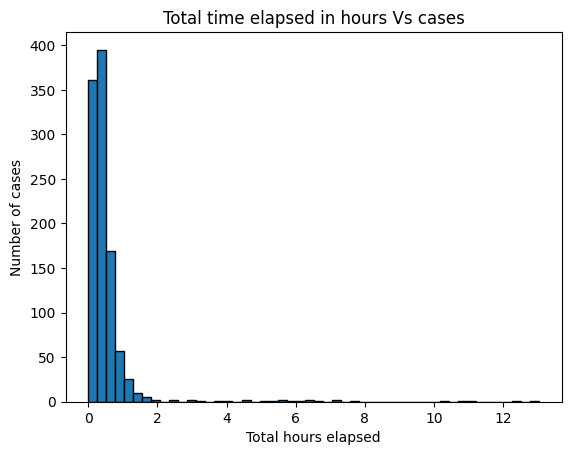

In [ ]:
#plot the frequency of cases against the total time elapsed
plt.hist(grouped_time['Total_hours'], bins=50, edgecolor='black')  # 'bins' determine the number of bins in the histogram
# Add title and labels
plt.title('Total time elapsed in hours Vs cases')
plt.xlabel('Total hours elapsed')
plt.ylabel('Number of cases')

# Show the plot
plt.show()
#print(grouped_time[grouped_time['Total_hours']>1])

From the above plot, we can see that there were some cases where total time elapsed beyond 5 hours. Sp lte us create another column in our main dataset, whether time has an impact on antibiotic administration

In [ ]:
#merging the total time elapsed column to the main dataset
new_data = new_data.merge(grouped_time, on = 'Case ID', how = 'left')
print(new_data.shape)

(2294, 190)


In [ ]:
#creatng a new column to check if the total time elpased is greater than 1 hour, as the initial one hour is critical
# for sepsis patients w.r.t IV antibiotics administration.
new_data['Time_gt_1hr'] = np.where(new_data['Total_hours']>1,1,0)
new_data.head(10)

,Case ID,Complete Timestamp,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,...,Diagnose_YB,Diagnose_YC,Diagnose_YD,Diagnose_Z,Diagnose_ZA,Diagnose_ZB,Diagnose_ZC,Diagnose_ZD,Total_hours,Time_gt_1hr
0,A,2014-10-22 19:15:41,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0.188611,0
1,A,2014-10-22 19:27:00,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0.188611,0
2,A,2014-10-22 19:27:00,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0.188611,0
3,A,2014-10-22 19:27:00,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0.188611,0
4,B,2014-12-21 20:04:24,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0.526667,0
5,B,2014-12-21 20:36:00,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0.526667,0
6,B,2014-12-21 20:36:00,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0.526667,0
7,C,2014-02-10 04:29:29,1,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0.608611,0
8,C,2014-02-10 05:06:00,1,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0.608611,0
9,D,2014-07-10 19:52:00,1,1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0.966667,0


In [ ]:
#grouping by case and getting the last readings of biomarkers CRP, Lactic acid, and Leucocytes, null values replaced by mean
diag_cols = ['Leucocytes','CRP','LacticAcid']
grouped_diag = new_data.groupby('Case ID')[diag_cols].agg(['last'])
grouped_diag.reset_index(inplace=True)
grouped_diag.columns = ['Case ID','Leucocytes_last','CRP_last','LacticAcid_last']
grouped_diag['Leucocytes_last'] = grouped_diag['Leucocytes_last'].fillna(grouped_diag['Leucocytes_last'].mean())
grouped_diag['CRP_last'] = grouped_diag['CRP_last'].fillna(grouped_diag['CRP_last'].mean())
grouped_diag['LacticAcid_last'] = grouped_diag['LacticAcid_last'].fillna(grouped_diag['LacticAcid_last'].mean())
#checking for abnormal values of these biomarkers and creating a new column 'Elevated_diag' and setting value as 1
def check_diag(each_row):
    if ((each_row['Leucocytes_last']> 12.0 or each_row['Leucocytes_last'] < 4.0) and each_row['CRP_last']>10.0 and each_row['LacticAcid_last']>2.0 ):
      return(1)
    else:
        return(0)
grouped_diag['Elevated_diag'] = grouped_diag.apply(check_diag, axis=1)
grouped_diag['Elevated_diag'].value_counts()

1    704
0    346
Name: Elevated_diag, dtype: int64

In [ ]:
grouped_diag.head(20)

,Case ID,Leucocytes_last,CRP_last,LacticAcid_last,Elevated_diag
0,A,9.600000,21.000000,2.200000,0
1,AA,8.600000,115.242623,2.011111,0
2,AAA,13.366587,115.242623,2.011111,1
3,AB,13.366587,48.000000,2.011111,1
4,ABA,13.366587,115.242623,2.011111,1
5,AC,8.800000,115.242623,2.011111,0
6,ACA,13.366587,342.000000,2.011111,1
7,AD,13.366587,115.242623,1.100000,0
8,ADA,13.366587,115.242623,0.700000,0
9,AE,8.200000,115.242623,2.011111,0


In [ ]:
new_data = new_data.merge(grouped_diag, on = 'Case ID',how = 'left' )

In [ ]:
#To create a case_based data set, we are keeping only the rows where activity_index=1,
#As we have populated all rows with values for missing columns there will not be any data loss
case_based_data = new_data.loc[new_data['activity_index']== 1] #prefix filteration
#fillling missing values of age with mean
mean_age = case_based_data['Age'].mean()
case_based_data['Age'] = case_based_data['Age'].fillna(mean_age)
case_based_data.shape

<ipython-input-64-fdf10c52bdf7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case_based_data['Age'] = case_based_data['Age'].fillna(mean_age)


(1037, 195)

In [ ]:
#Scaling values of biomarker columns
case_based_data['Leucocytes_last'] = scaler.fit_transform(case_based_data['Leucocytes_last'].values.reshape(-1,1))
case_based_data['CRP_last'] = scaler.fit_transform(case_based_data['CRP_last'].values.reshape(-1,1))
case_based_data['LacticAcid_last'] = scaler.fit_transform(case_based_data['LacticAcid_last'].values.reshape(-1,1))
print(case_based_data.shape)

(1037, 195)


<ipython-input-65-24879c94cdb5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case_based_data['Leucocytes_last'] = scaler.fit_transform(case_based_data['Leucocytes_last'].values.reshape(-1,1))
<ipython-input-65-24879c94cdb5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case_based_data['CRP_last'] = scaler.fit_transform(case_based_data['CRP_last'].values.reshape(-1,1))
<ipython-input-65-24879c94cdb5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

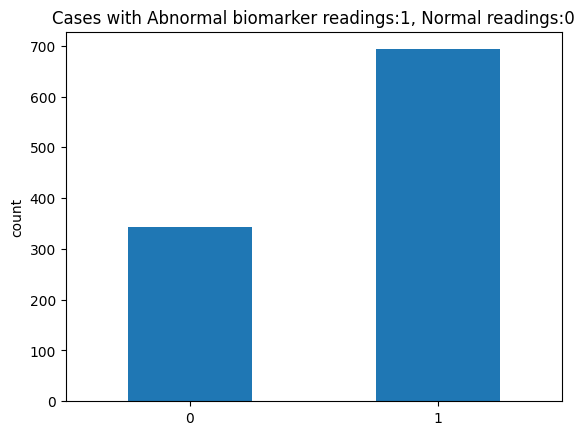

In [ ]:
#plotting number of cases with Elevated_diag
case_based_data['Elevated_diag'].value_counts().sort_index().plot(kind='bar', rot=0, ylabel='count',title = 'Cases with Abnormal biomarker readings:1, Normal readings:0')
plt.show()

In [ ]:
#removing original biomarkers column as we have created new aggregated columns
case_based_data = case_based_data.drop(columns = ['Leucocytes','CRP','LacticAcid'])
case_based_data.shape

(1037, 192)

In [ ]:
#filling empty binary columns with mode of values
for i in bin_val:
    mode_value = case_based_data[i].mode()[0]
    case_based_data[i].fillna(mode_value, inplace=True)

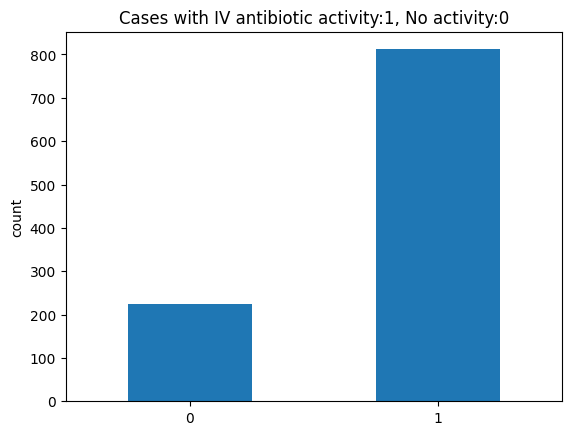

In [ ]:
#plotting number of cases with and without Antibiotics
case_based_data['IV_Antibiotics'].value_counts().sort_index().plot(kind='bar', rot=0, ylabel='count',title = 'Cases with IV antibiotic activity:1, No activity:0')
# # Add a legend
# plt.legend()
plt.show()


                      Age  Leucocytes_last  CRP_last  LacticAcid_last
Age              1.000000         0.011313 -0.000557         0.072683
Leucocytes_last  0.011313         1.000000  0.055967         0.017983
CRP_last        -0.000557         0.055967  1.000000        -0.045705
LacticAcid_last  0.072683         0.017983 -0.045705         1.000000


<Axes: >

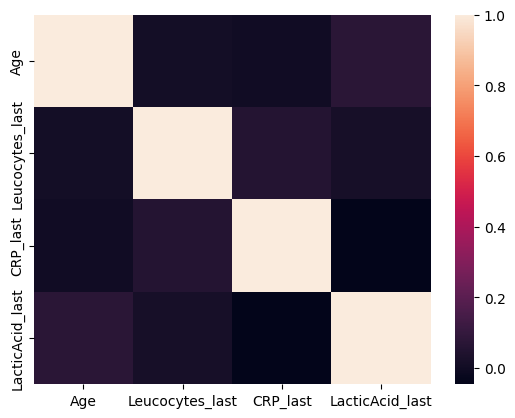

In [ ]:
#Let's check if there are any correlation between numerical columns in our dataset and plot a heatmap
df_num = case_based_data[['Age','Leucocytes_last','CRP_last','LacticAcid_last']]
print(df_num.corr())
sns.heatmap(df_num.corr())

In [ ]:
#Dropping columns not relevant to model implementation
case_based_data = case_based_data.drop(columns = ['Case ID','activity_index','Complete Timestamp','Activity_Admission NC','Activity_LacticAcid'])

In [ ]:
#selecting the features for prediction in X_feat set and target variable as y_feat
X_feat= case_based_data.drop(['IV_Antibiotics'],axis=1)
y_feat = case_based_data['IV_Antibiotics']

### Feature selection

In [ ]:
#Let us rank the features based on their importance
randfor_features = RandomForestClassifier()
randfor_features.fit(X_feat,y_feat)
imp_features = randfor_features.feature_importances_
imp_features_df = pd.DataFrame({'Feature':X_feat.columns,'Importance':imp_features})
imp_features_df = imp_features_df.sort_values(by = 'Importance', ascending = False)
imp_features_df.head(20)

,Feature,Importance
0,InfectionSuspected,0.113621
24,add_biomark_check,0.103760
13,SIRSCriteria2OrMore,0.096792
23,SIRSCriteria2OrMore_satisfied,0.084849
6,Infusion,0.081737
19,DiagnosticLacticAcid,0.076649
9,DiagnosticIC,0.056233
1,DiagnosticBlood,0.054028
15,SIRSCritTemperature,0.042012
5,SIRSCritHeartRate,0.039820


In [ ]:
# #plotting feature importance
# plt.bar(imp_features_df['Feature'], imp_features_df['Importance'], sort= True, ascending=False, rot=0, xlabel='Features', ylabel='Importance of feature',title = 'Importance of features')
# # # Add a legend
# # plt.legend()
# plt.show()

imp_features_chart  = imp_features_df[:20]
imp_bar = px.bar(imp_features_chart, x="Feature", y="Importance")
imp_bar.show()

In [ ]:
list(imp_features_df['Feature'])

['InfectionSuspected',
 'add_biomark_check',
 'SIRSCriteria2OrMore',
 'SIRSCriteria2OrMore_satisfied',
 'Infusion',
 'DiagnosticLacticAcid',
 'DiagnosticIC',
 'DiagnosticBlood',
 'SIRSCritTemperature',
 'SIRSCritHeartRate',
 'DiagnosticXthorax',
 'DiagnosticECG',
 'Total_hours',
 'Leucocytes_last',
 'Age',
 'SIRSCritTachypnea',
 'DiagnosticUrinaryCulture',
 'CRP_last',
 'DiagnosticUrinarySediment',
 'DiagnosticArtAstrup',
 'Elevated_diag',
 'LacticAcid_last',
 'Age_Risk',
 'Time_gt_1hr',
 'Diagnose_C',
 'Diagnose_S',
 'Diagnose_QC',
 'org:group_A',
 'org:group_L',
 'Diagnose_P',
 'Diagnose_EA',
 'DiagnosticOther',
 'Diagnose_E',
 'Diagnose_N',
 'Diagnose_GA',
 'Diagnose_B',
 'Diagnose_Q',
 'Diagnose_LC',
 'SIRSCritLeucos',
 'Diagnose_ND',
 'DiagnosticSputum',
 'Diagnose_G',
 'org:group_B',
 'Diagnose_IC',
 'Diagnose_AA',
 'Diagnose_H',
 'Hypotensie',
 'Activity_Leucocytes',
 'Diagnose_D',
 'Diagnose_JD',
 'Diagnose_W',
 'Activity_ER Registration',
 'Diagnose_Z',
 'Activity_CRP',
 'Disf

In [ ]:
##selecting only the top 20 features for training the model.
X_feat = X_feat.drop([
    'LacticAcid_last',
 'Age_Risk',
 'Elevated_diag',
 'Time_gt_1hr',
 'Diagnose_C',
 'org:group_L',
 'Diagnose_EA',
 'org:group_A',
 'Diagnose_B',
 'Diagnose_S',
 'Diagnose_QC',
 'Diagnose_H',
 'Diagnose_N',
 'Diagnose_Q',
 'Diagnose_P',
 'Diagnose_ND',
 'DiagnosticSputum',
 'DiagnosticOther',
 'Diagnose_AA',
 'Activity_ER Registration',
 'Diagnose_D',
 'Diagnose_E',
 'Diagnose_R',
 'Diagnose_G',
 'Diagnose_LC',
 'DisfuncOrg',
 'Hypotensie',
 'Diagnose_W',
 'Activity_Leucocytes',
 'SIRSCritLeucos',
 'Diagnose_GA',
 'Hypoxie',
 'org:group_B',
 'Diagnose_Z',
 'Activity_CRP',
 'Activity_IV Liquid',
 'Diagnose_MD',
 'Diagnose_F',
 'Diagnose_K',
 'Diagnose_JD',
 'Diagnose_IC',
 'Diagnose_OB',
 'Diagnose_FA',
 'Diagnose_BB',
 'Diagnose_VA',
 'Diagnose_CA',
 'Diagnose_GB',
 'Diagnose_UD',
 'Diagnose_BA',
 'Diagnose_KB',
 'Diagnose_SB',
 'Diagnose_QA',
 'Diagnose_RD',
 'Diagnose_LB',
 'Diagnose_YD',
 'Diagnose_RA',
 'Diagnose_LA',
 'Diagnose_RC',
 'Diagnose_EE',
 'Diagnose_Y',
 'Diagnose_AB',
 'Diagnose_IA',
 'Diagnose_FE',
 'Diagnose_U',
 'Diagnose_WB',
 'Diagnose_JC',
 'Diagnose_LE',
 'Diagnose_JB',
 'Diagnose_HA',
 'Diagnose_WA',
 'Oligurie',
 'Diagnose_WD',
 'Diagnose_FD',
 'Diagnose_GC',
 'Diagnose_PC',
 'Diagnose_PE',
 'Diagnose_KA',
 'Diagnose_XA',
 'Diagnose_RB',
 'Diagnose_M',
 'Diagnose_MA',
 'Diagnose_IE',
 'Diagnose_CB',
 'Diagnose_DA',
 'Diagnose_X',
 'Diagnose_QE',
 'DiagnosticLiquor',
 'Diagnose_YC',
 'Diagnose_ID',
 'Diagnose_UB',
 'Diagnose_SC',
 'Diagnose_WC',
 'Diagnose_CD',
 'Diagnose_CC',
 'Diagnose_XD',
 'Diagnose_TA',
 'Diagnose_VB',
 'Diagnose_CE',
 'Diagnose_HE',
 'Diagnose_DC',
 'Diagnose_EB',
 'Diagnose_AC',
 'Diagnose_MC',
 'Diagnose_OC',
 'Diagnose_SA',
 'Diagnose_GE',
 'Diagnose_BC',
 'Diagnose_HB',
 'Diagnose_JA',
 'Diagnose_UA',
 'Diagnose_XC',
 'Diagnose_GD',
 'Diagnose_ZD',
 'Diagnose_KC',
 'Diagnose_L',
 'Diagnose_HD',
 'Diagnose_TB',
 'Diagnose_A',
 'Diagnose_VC',
 'Diagnose_ME',
 'Diagnose_IB',
 'Diagnose_UC',
 'Diagnose_ZA',
 'Diagnose_VD',
 'Diagnose_V',
 'Diagnose_ED',
 'Diagnose_HC',
 'Diagnose_BD',
 'Diagnose_DD',
 'Diagnose_OE',
 'Diagnose_KD',
 'Diagnose_J',
 'Diagnose_O',
 'Diagnose_XB',
 'Diagnose_DE',
 'Diagnose_T',
 'Diagnose_YA',
 'Diagnose_JE',
 'Diagnose_KE',
 'Diagnose_ZB',
 'Diagnose_YB',
 'Diagnose_ZC',
 'Diagnose_FB',
 'Diagnose_EC',
 'org:group_T',
 'org:group_M',
 'org:group_G',
 'Diagnose_I',
 'Diagnose_FC',
 'Diagnose_MB',
 'Diagnose_TC',
 'Diagnose_BE',
 'Diagnose_QB',
 'Diagnose_PD',
 'Diagnose_PB',
 'Diagnose_SD',
 'Diagnose_PA',
 'Diagnose_TD',
 'Diagnose_NB',
 'Diagnose_OD',
 'Diagnose_DB',
 'Diagnose_AE',
 'Diagnose_AD',
 'Diagnose_OA',
 'Diagnose_QD',
 'Diagnose_NC'
    ],axis=1)

y = case_based_data['IV_Antibiotics']

In [ ]:
#checking for correlation between features in data and plotting as a heat map
feat_corr = X_feat.corr()
pc_fig = px.imshow(feat_corr)
pc_fig.show()

There are so many correlated values in our data, so lets get the least correlated 10 values and create a new dataset to improve model performance.

In [ ]:
#sort correlation values and get 10 least correlated values and create a new dataset with the selected features for training the model.
least_correlated_attributes = feat_corr.mean().sort_values().index[:10]
X = X_feat[least_correlated_attributes]

In [ ]:
X.head(10)

,Total_hours,CRP_last,Leucocytes_last,Age,DiagnosticArtAstrup,SIRSCritTachypnea,DiagnosticUrinaryCulture,DiagnosticUrinarySediment,SIRSCritHeartRate,SIRSCritTemperature
0,0.188611,-0.932203,-0.740331,0.857143,1,1,1,1,1,1
4,0.526667,-0.004237,-0.636282,-0.285714,0,1,1,1,1,1
7,0.608611,-0.532870,-0.580110,0.000000,1,0,1,1,1,1
9,0.966667,-0.296610,-0.636282,0.428571,1,1,0,0,1,1
11,0.259444,-0.532870,-0.636282,0.571429,1,1,1,1,1,1
13,0.234167,-0.532870,-0.486188,-0.142857,0,0,0,0,1,1
15,0.636944,-0.532870,-0.636282,0.142857,0,0,1,1,1,1
17,0.532778,-0.411017,-0.636282,0.714286,0,1,0,0,1,0
19,0.231389,-0.532870,-0.636282,0.714286,1,0,1,1,1,1
21,0.187500,-0.838983,-0.636282,0.714286,0,1,0,1,1,1


##Splitting data into training and test set

In [ ]:
# Step 1: Split the data into train (60%) and a temporary set 'tst_val'(40%) initially
X_train, X_tst_val, y_train, y_tst_val = train_test_split(X, y, test_size=0.4, random_state=42)

# Step 2: Split the temporary set into test (50%) and validation (50%)
X_test, X_val, y_test, y_val = train_test_split(X_tst_val, y_tst_val, test_size=0.5, random_state=42)

print(X_train.shape)#size of training dataset for independent features
print(y_train.shape)#size of training dataset for target feature
print(X_test.shape)#test feature set
print(y_test.shape)#test target variable
print(X_val.shape)#validation feature set
print(y_val.shape)#validation target variable

(622, 10)
(622,)
(207, 10)
(207,)
(208, 10)
(208,)


##Logistic regression model implementation

In [ ]:
#Create a stratified k-fold object for cross-validation to balance the ratio of the target variable in all folds
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Instantiate your classifier with class weights
LR_classifier = LogisticRegression(class_weight='balanced', random_state=42)

#Perform cross-validation using stratified folds
cv_scores = cross_val_score(LR_classifier, X_train, y_train, cv=stratified_kfold, scoring='accuracy')

# Print the cross-validation scores
print('***************Logistic regression model efficiency scores************')
#print("Cross-validation scores for training set: ", cv_scores)
print("\nMean accuracy for training set: ", np.mean(cv_scores))

#Train your model on the entire training set
LR_classifier.fit(X_train, y_train)

#Make predictions on the test set
y_test_predicted = LR_classifier.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_predicted)
print(f"\nAccuracy for test data set: {accuracy_test:.2f}\n")
# Print classification report
print(classification_report(y_test, y_test_predicted))
# Print confusion matrix
cm_test = confusion_matrix(y_test, y_test_predicted)
print("Confusion Matrix for test set:")
print(cm_test)

***************Logistic regression model efficiency scores************

Mean accuracy for training set:  0.9099612903225806

Accuracy for test data set: 0.88

              precision    recall  f1-score   support

           0       0.70      0.82      0.76        45
           1       0.95      0.90      0.92       162

    accuracy                           0.88       207
   macro avg       0.82      0.86      0.84       207
weighted avg       0.89      0.88      0.89       207

Confusion Matrix for test set:
[[ 37   8]
 [ 16 146]]


In [ ]:
#Let us make predictions for the validation set
y_val_predicted = LR_classifier.predict(X_val)
accuracy_val = accuracy_score(y_val, y_val_predicted)
print(f"Accuracy for validation data set: {accuracy_val:.2f}")
# Print classification report
print(classification_report(y_val, y_val_predicted))
# Print confusion matrix
cm_val = confusion_matrix(y_val, y_val_predicted)
print("Confusion Matrix for validation set:")
print(cm_val)

Accuracy for validation data set: 0.91
              precision    recall  f1-score   support

           0       0.76      0.84      0.80        45
           1       0.96      0.93      0.94       163

    accuracy                           0.91       208
   macro avg       0.86      0.89      0.87       208
weighted avg       0.91      0.91      0.91       208

Confusion Matrix for validation set:
[[ 38   7]
 [ 12 151]]


### ROC and AUC curves

<ipython-input-63-e7e2f5f64055>:7: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.



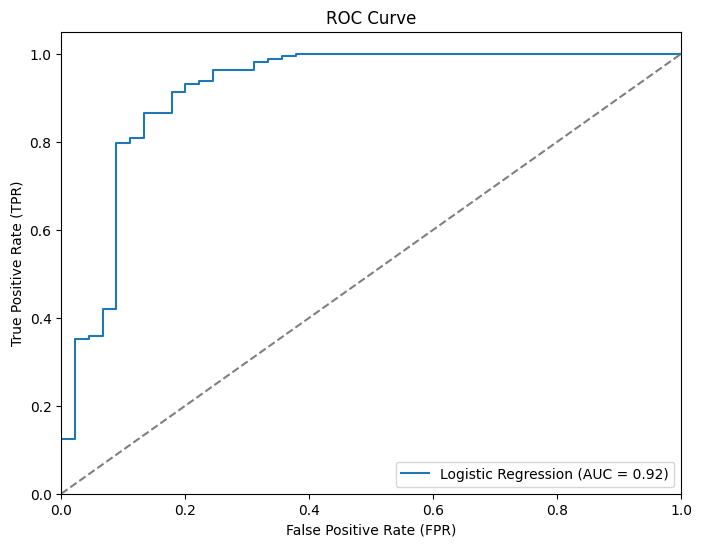

In [ ]:
y_prob_lr = LR_classifier.predict_proba(X_test)[:, 1]  # Probability of class 1
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_prob_lr)
auc_lr = roc_auc_score(y_test, y_prob_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot([0, 1], [0, 1], 'k--', color='gray')
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Random Forest model implementation

In [ ]:
# Instantiate your classifier with class weights
randForModel = RandomForestClassifier(n_estimators=100,random_state=42, class_weight='balanced')

#Perform cross-validation using stratified folds
cv_scores_rf = cross_val_score(randForModel, X_train, y_train, cv=stratified_kfold, scoring='accuracy')

# Print the cross-validation scores
print('***************Random Forest model efficiency scores************')
print("Cross-validation scores for training set: ", cv_scores_rf)
print("\nMean accuracy for training set: ", np.mean(cv_scores_rf))

#Train your model on the entire training set
randForModel.fit(X_train, y_train)

y_test_predicted_rf = randForModel.predict(X_test)
accuracy_test_rf = accuracy_score(y_test, y_test_predicted_rf)
print(f"Accuracy for test data set : {accuracy_test_rf:.2f}")
# Print classification report
print(classification_report(y_test, y_test_predicted_rf))
# Print confusion matrix
cm_test_rf = confusion_matrix(y_test, y_test_predicted_rf)
print("Confusion Matrix for test set:")
print(cm_test_rf)

***************Random Forest model efficiency scores************
Cross-validation scores for training set:  [0.944      0.952      0.93548387 0.93548387 0.94354839]

Mean accuracy for training set:  0.9421032258064516
Accuracy for test data set : 0.91
              precision    recall  f1-score   support

           0       0.97      0.62      0.76        45
           1       0.90      0.99      0.95       162

    accuracy                           0.91       207
   macro avg       0.94      0.81      0.85       207
weighted avg       0.92      0.91      0.91       207

Confusion Matrix for test set:
[[ 28  17]
 [  1 161]]


In [ ]:
#Let us make predictions for the validation set
y_val_predicted_rf = randForModel.predict(X_val)
accuracy_val_rf = accuracy_score(y_val, y_val_predicted_rf)
print(f"Accuracy for validation data set: {accuracy_val_rf:.2f}")
# Print classification report
print(classification_report(y_val, y_val_predicted_rf))
# Print confusion matrix
cm_val_rf = confusion_matrix(y_val, y_val_predicted_rf)
print("Confusion Matrix for validation set:")
print(cm_val_rf)

Accuracy for validation data set: 0.93
              precision    recall  f1-score   support

           0       0.97      0.69      0.81        45
           1       0.92      0.99      0.96       163

    accuracy                           0.93       208
   macro avg       0.94      0.84      0.88       208
weighted avg       0.93      0.93      0.92       208

Confusion Matrix for validation set:
[[ 31  14]
 [  1 162]]


### ROC curves and AUC scores

<ipython-input-66-af2a36b9156e>:7: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.



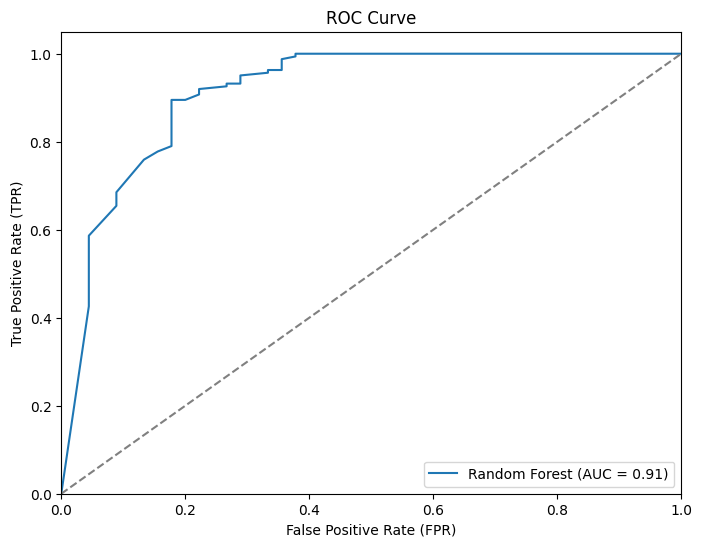

In [ ]:
y_prob_rf = randForModel.predict_proba(X_test)[:, 1]  # Probability of class 1
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--', color='gray')
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()